**Noise Injection with the Laplace Mechanism**

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

This notebook explores one disclosure avoidance technique that applies Laplacian-distributed noise to PUMS data counts. Let's begin by loading data.

In [2]:
pa = pd.read_csv("psam_p42.csv")
asn_pa = pa.query('AGEP>=18 and RACASN==1')
asn_pa.groupby('RAC2P').count().head()

,RT,SERIALNO,DIVISION,SPORDER,PUMA,REGION,ST,ADJINC,PWGTP,AGEP,...,PWGTP71,PWGTP72,PWGTP73,PWGTP74,PWGTP75,PWGTP76,PWGTP77,PWGTP78,PWGTP79,PWGTP80
RAC2P,,,,,,,,,,,,,,,,,,,,,
38,3645,3645,3645,3645,3645,3645,3645,3645,3645,3645,...,3645,3645,3645,3645,3645,3645,3645,3645,3645,3645
39,118,118,118,118,118,118,118,118,118,118,...,118,118,118,118,118,118,118,118,118,118
40,66,66,66,66,66,66,66,66,66,66,...,66,66,66,66,66,66,66,66,66,66
41,51,51,51,51,51,51,51,51,51,51,...,51,51,51,51,51,51,51,51,51,51
42,251,251,251,251,251,251,251,251,251,251,...,251,251,251,251,251,251,251,251,251,251


In [3]:
# a 2D table, row = educational attainment, col = race by RAC2P (asian ethnicity)
asn_pa_ed = asn_pa.groupby(['RAC2P','SCHL']).size().unstack()
asn_pa_ed.fillna(0)
asn_pa_ed.describe()

SCHL,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,...,15.0,16.0,17.0,18.0,19.0,20.0,21.0,22.0,23.0,24.0
count,21.000000,2.0,3.000000,6.000000,8.000000,12.000000,11.000000,12.000000,15.000000,10.000000,...,18.000000,22.000000,19.000000,22.000000,22.000000,20.000000,23.000000,22.000000,19.000000,20.000000
mean,28.142857,1.0,1.666667,1.500000,2.625000,2.916667,3.454545,5.583333,8.400000,5.600000,...,22.111111,94.636364,10.578947,30.727273,73.363636,30.550000,145.565217,89.909091,38.000000,36.150000
std,47.244350,0.0,0.577350,1.224745,2.326094,2.574643,2.423371,7.464563,12.871896,6.619836,...,32.021847,136.995845,13.459056,46.767084,113.569171,40.325615,253.861241,209.129923,69.628379,77.954963
min,1.000000,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,2.000000,1.000000,3.000000,1.000000,1.000000,1.000000
25%,3.000000,1.0,1.500000,1.000000,1.000000,1.000000,1.500000,1.000000,1.000000,2.000000,...,4.250000,12.500000,1.000000,5.000000,5.500000,3.000000,14.000000,4.250000,2.500000,2.000000
50%,10.000000,1.0,2.000000,1.000000,2.000000,2.000000,3.000000,2.500000,3.000000,2.500000,...,6.500000,25.500000,3.000000,8.000000,17.500000,7.000000,29.000000,14.500000,8.000000,8.500000
75%,22.000000,1.0,2.000000,1.000000,3.000000,3.250000,4.500000,4.250000,11.000000,7.000000,...,15.250000,117.500000,17.500000,29.750000,84.250000,59.500000,129.000000,42.750000,41.500000,19.250000
max,204.000000,1.0,2.000000,4.000000,8.000000,9.000000,8.000000,22.000000,51.000000,22.000000,...,99.000000,477.000000,40.000000,158.000000,388.000000,119.000000,1019.000000,894.000000,288.000000,311.000000


In [4]:
all_pa_ed = asn_pa.groupby('SCHL').size()

**The Laplace Mechanism**
The input is mu - a number or a numpy array, along with the privacy budget epsilon and sensitivity of the query that produced mu.

In [5]:
def laplace_mech(mu, epsilon, sensitivity=1.0):
    """Implementation of the Laplace Mechanism that adds Laplacian-distributed noise to a function.
  　
    Args:
      mu (float or numpy array): the true answer
      epsilon(int): the privacy budget
      sensitivity (float): the global sensitivity of the query
    """
    eps = epsilon/float(sensitivity)
    scale = 1/eps
    np_shape = np.shape(mu)
    shape = None if np_shape == () else np_shape
    z = np.random.laplace(0.0, scale=scale, size=shape)
    return mu + z

**The L1 Norm**
How can we estimate the error of a differentially private algorithm? In this simple scenario involving the laplace mechanism, the L1 norm is a natural metric.

In [6]:
def avg_l1_laplace(epsilon, mu, n=1000):
    """Takes the average error of the laplace mechanism on an array over n samples.
  　
    Args:
      epsilon (int): the privacy budget
      mu (float or numpy array): the true answer
      n (int): number of samples
    """
    total = 0
    for i in range(n):
        noisy_arr = laplace_mech(mu, epsilon, sensitivity=1.0)
        accuracy = 1 - (np.linalg.norm(noisy_arr-mu, 1)/(2*noisy_arr.shape[1]))
        total += accuracy
    return total/n

Let's take a closer look at the tradeoff between privacy loss vs. accuracy with our current model using the Laplace mechanism and L1 norm.

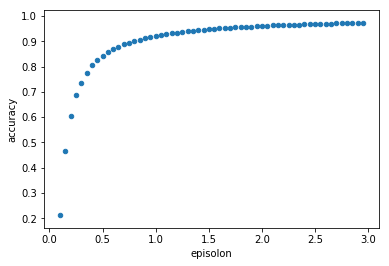

In [7]:
orig_arr = pd.DataFrame(all_pa_ed).T
accuracy_df = pd.DataFrame()
eps_range = np.arange(.1,3.0,.05)
accuracy_df['episolon'] = eps_range
accuracy_df['accuracy'] = [avg_l1_laplace(x, orig_arr) for x in eps_range]
accuracy_df.plot.scatter('episolon', 'accuracy')
plt.show()

This type of measure between privacy loss and accuracy is what gets submitted to the DRB for approval. Officials most often estimate with epsilon values between 1 and 9.

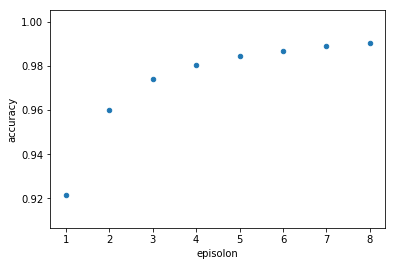

In [8]:
orig_arr = pd.DataFrame(all_pa_ed).T
accuracy_df = pd.DataFrame()
eps_range = np.arange(1,9.0,1)
accuracy_df['episolon'] = eps_range
accuracy_df['accuracy'] = [avg_l1_laplace(x, orig_arr) for x in eps_range]
accuracy_df.plot.scatter('episolon', 'accuracy')
plt.show()